In [1]:
using Plots; pyplot(size = (600,400))
using StatPlots

In [2]:
include("src/CHMM.jl")

gen_normals (generic function with 1 method)

In [3]:
K = 4
D = 2

# doesn't line up in format with NGSIM data (specifically, no time/frame aspect)
model = rand_chmm(K, D)
(X, Z, trajptr, pairs_full) = rand_trajs(model, 
    T_range=100:1_000, N_pairs=1_500)
num_trajs = length(trajptr) - 1
num_obs = size(X, 2)

1638478

In [4]:
max_wiggle = 10
num_pairs = round(Int, length(pairs_full) / 1)
pairs = zeros(Int, 4, num_pairs)
pairs_to_keep = randperm(length(pairs_full))[1:num_pairs]

for (i, ind) in enumerate(pairs_to_keep)
    c1, c2 = pairs_full[ind]
    s_wiggle = rand(1:max_wiggle)
    e_wiggle = rand(1:max_wiggle)

    r1 = get_trajectory_range(trajptr, c1)
    pairs[1, i] = first(r1) + s_wiggle
    pairs[2, i] = last(r1) - e_wiggle

    r2 = get_trajectory_range(trajptr, c2)
    pairs[3, i] = first(r2) + s_wiggle
    pairs[4, i] = last(r2) - e_wiggle
end

## EM

In [5]:
curr = chmm_from_data(X, K)
orig = deepcopy(curr)
suff = ChmmSuffStats(curr)
;

In [ ]:
(curr, loglike_hist) = chmm_em!(curr, suff, X, trajptr, pairs; N_iters=100, print_every=5)
;


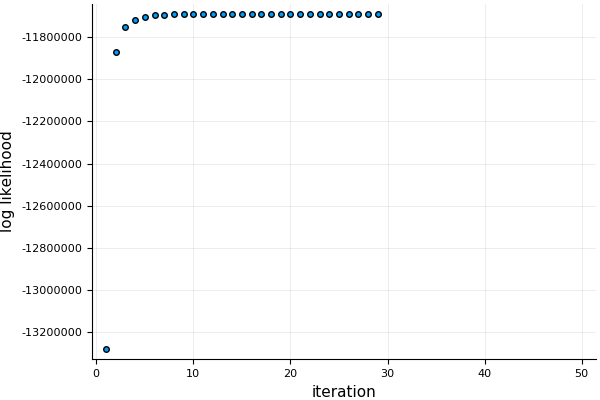

In [7]:
scatter(loglike_hist, legend=false)
ylabel!("log likelihood")
xlabel!("iteration")

In [21]:
@assert all( diff(filter(isfinite, loglike_hist)) .> 0 )


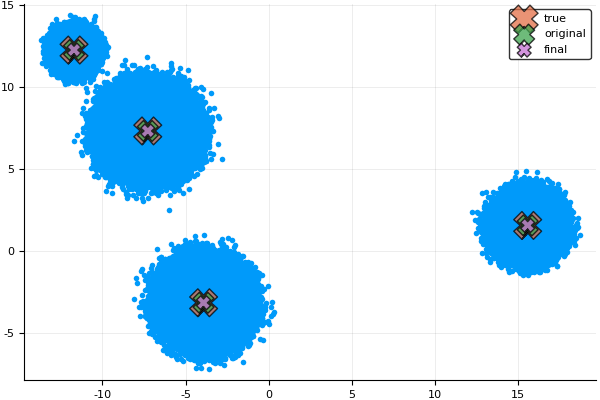

In [8]:
m = hcat(model.μs...)'
mo = hcat(orig.μs...)'
mhat = hcat(curr.μs...)'

scatter(X[1, :], X[2, :], label="", marker=(:circle, stroke(0)))
scatter!(m[:, 1], m[:, 2], marker=:X, ms=20, label="true", alpha=0.75)
scatter!(mo[:, 1], mo[:, 2], marker=:X, ms=15, label="original", alpha=0.75)
scatter!(mhat[:,1], mhat[:, 2], marker=:X, ms=10, label="final", alpha=0.75)

# Analysis

In [9]:
true_to_est = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est[i] = indmin(r)
end
true_to_est_full = vec(outer(true_to_est))
;

## P

In [28]:
#
# factor true dist
#

P_errs = vec(model.P[true_to_est, true_to_est, true_to_est] .- curr.P)
# full
(mean(P_errs), std(P_errs))

(5.637851296924623e-18, 0.1669855776993992)


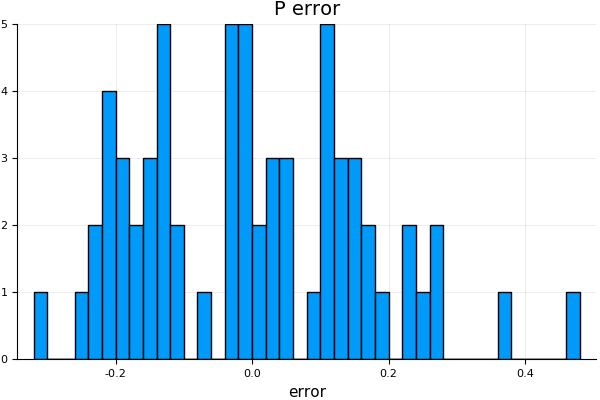

In [27]:
histogram(P_errs, bins=50, legend=false, xlabel="error", title="P error")

## π₀

In [30]:
p_errs = vec(model.π0[true_to_est] - curr.π0)
(mean(p_errs), std(p_errs))

(-2.0816681711721685e-17, 0.16528556314717086)


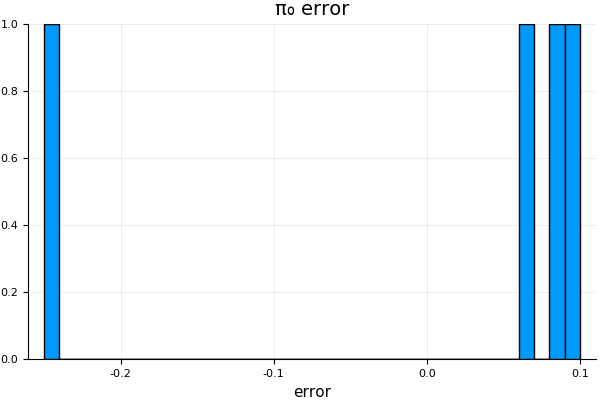

In [31]:
histogram(p_errs, bins=50, legend=false, xlabel="error", title="π₀ error")

## μs

In [48]:
m_errs = vcat([vec((model.μs[true_to_est[i]] .- curr.μs[i])./model.μs[i]) for i in 1:K]...)
(mean(m_errs), std(m_errs))

(-6.385246635521989e-5, 0.00029896115594985957)


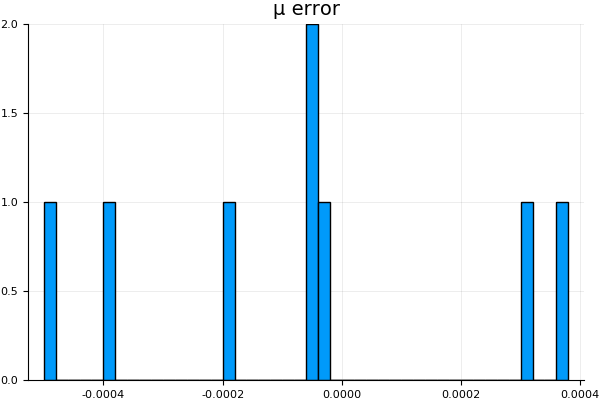

In [42]:
histogram(m_errs, legend=false, bins=50, title="μ error")

## Σs

In [49]:
S_errs = vcat([vec( model.Σs[true_to_est[i]] .- curr.Σs[i] ) for i in 1:K]...)
(mean(S_errs), std(S_errs))

(-0.00018498254943780101, 0.0019096762721925278)


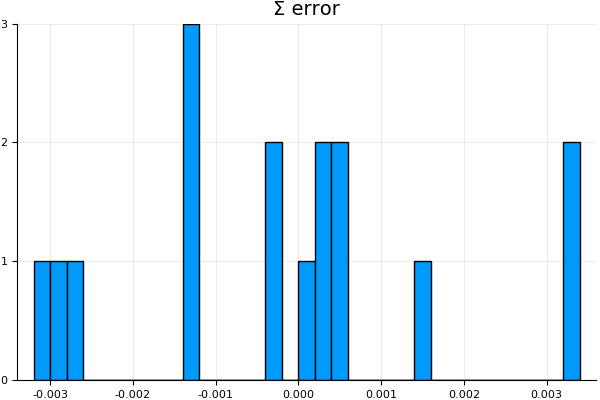

In [47]:
histogram(S_errs, bins=50, legend=false, title="Σ error")